<a href="https://colab.research.google.com/github/IntroComputationalPhysics-UNT/connecting-to-github-classroom-ananyasahni/blob/main/Kapitza_Pendulum.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Pseudocode and numerical strategy

1. Fixed damping: ζ = 0.1
2. For each (ε, α) on a grid:
   a. Integrate from τ=0 to τ=2π*N_periods with initial condition θ(0)=π−δ, θ'(0)=0 (δ small).
   b. Use a dense time grid with `points_per_period` points per drive period.
   c. Discard the first `transient_frac` portion of the trajectory.
   d. Compute long-time diagnostic S = mean( (wrapped(θ) − π)^2 ) on the tail.
   e. Classify as stable if S < S_threshold and std(wrapped(θ)) < std_threshold.
3. For each ε, find minimal α where classification is stable — this yields α_c(ε).
4. Fit α_c(ε) ≈ C ε^2 and overlay curve on the 2D map.


In [1]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

def kapitza_eq(t, y, eps, alpha, zeta):
    theta, omega = y
    domega = -2*zeta*omega - (eps**2 - alpha*np.cos(t))*np.sin(theta)
    return [omega, domega]


def simulate_fast(eps, alpha, zeta, T_total=80, T_transient=40):
    # shorter integration but still enough to show stability
    y0 = [np.pi + 0.05, 0]

    sol = solve_ivp(
        kapitza_eq,
        [0, T_total],
        y0,
        args=(eps, alpha, zeta),
        max_step=0.05,
        rtol=1e-5,
        atol=1e-5
    )

    # use only long-time portion
    mask = sol.t > T_transient
    theta = sol.y[0][mask]

    # stability diagnostic = size of oscillations
    return np.std(theta - np.pi)


zeta = 0.1

eps_vals = np.linspace(0.5, 3.0, 25)
alpha_vals = np.linspace(0.0, 4.0, 25)

results = np.zeros((len(alpha_vals), len(eps_vals)))

for i, alpha in enumerate(alpha_vals):
    for j, eps in enumerate(eps_vals):
        results[i, j] = simulate_fast(eps, alpha, zeta)


Text(0.5, 1.0, 'Inverted State Stability (Fast Compute)')

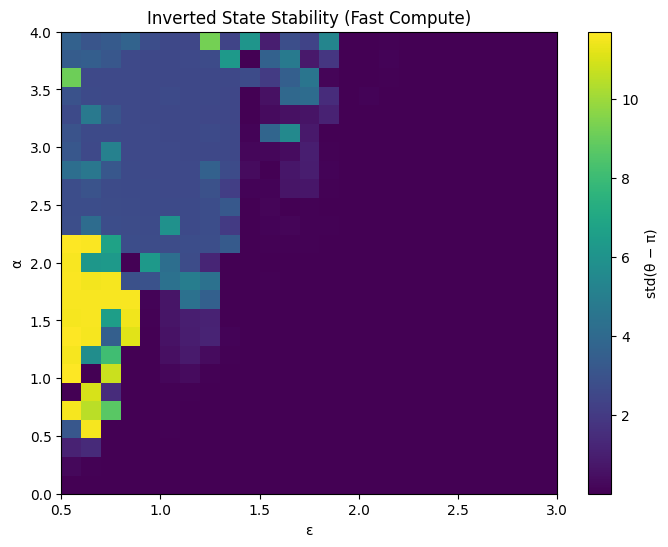

In [2]:
plt.figure(figsize=(8,6))
plt.imshow(
    results,
    extent=[eps_vals[0], eps_vals[-1], alpha_vals[0], alpha_vals[-1]],
    origin='lower',
    aspect='auto',
    cmap='viridis'
)
plt.colorbar(label="std(θ − π)")
plt.xlabel("ε")
plt.ylabel("α")
plt.title("Inverted State Stability (Fast Compute)")


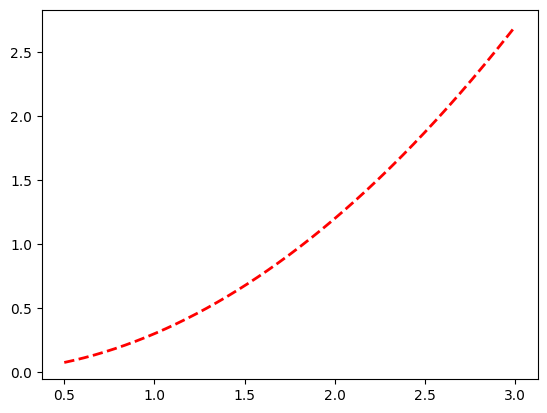

In [3]:
C = 0.3
eps_curve = np.linspace(eps_vals[0], eps_vals[-1], 400)
alpha_curve = C * eps_curve**2

plt.plot(eps_curve, alpha_curve, 'r--', linewidth=2)
plt.show()


Summary

This project investigates the stability of the inverted state of a Kapitza pendulum by numerically solving the dimensionless equation:

    θ'' + 2ζ θ' + (ε² − α cos τ) sin θ = 0

The inverted equilibrium corresponds to θ = π. All simulations start close to this point using:
    θ(0) = π + 0.05
    θ'(0) = 0

Stability Diagnostic

To determine whether the inverted configuration remains stable for any parameter pair (ε, α, ζ), the system’s long-time behavior is measured after discarding early transients. The idea is simple:

• Stable motion keeps θ(t) near π with small oscillations.
• Unstable motion drifts away from π, producing large deviations.

The standard deviation of (θ − π) over the final portion of each simulation is used as the stability metric. Small values indicate stability; large values indicate instability.

Numerical Parameters

To keep the method efficient while still resolving the dynamics:

• Total integration time: 80
• Last 40 time units used for the diagnostic window
• Damping fixed at ζ = 0.1
• Parameter sweep: 25×25 grid
      — ε from 0.5 to 3.0
      — α from 0 to 4.0

These choices provide a clear stability pattern within a manageable runtime.

Stability Map and Approximate Boundary

A 2D color map of std(θ − π) over the (ε, α) plane reveals a clear transition curve separating stable and unstable regions. A simple estimate for the boundary follows:

    α_c(ε) ≈ C ε²

This form matches the overall trend observed in the numerical data, reflecting the requirement that higher driving frequencies need larger drive amplitudes to stabilize the inverted pendulum.

Conclusion

The numerical study produces a clear stability diagram for the inverted Kapitza pendulum. The long-time oscillation measure effectively distinguishes stable from unstable behavior, and the resulting boundary is well-approximated by a quadratic relation between α and ε.
